**Problem 1 :** Using the images (aerobic-[001-022].bmp) provided on the class materials site,
experiment with simple “motion detection” between consecutive frames using (abs)
image differencing. Clean-up and remove any tiny regions (e.g., use techniques such
as bwareaopen, median filtering, etc.). Experiment with different thresholds. [2 pts]

In [7]:
# Q1: minimal motion via abs differencing + cleanup
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---- paths/params (edit as needed) ----
DATA_DIR = "data/"     # folder with aerobic-001.bmp ... aerobic-022.bmp
PATTERN  = "aerobic-*.bmp"
T        = 0.05               # fixed threshold in [0,1]
MED_K    = 3                  # median filter window (odd)
MIN_SIZE = 20                 # remove connected components smaller than this (px)


In [8]:
def load_gray01(path):
    return np.asarray(Image.open(path).convert("L"), np.float32) / 255.0

def load_sequence(data_dir=DATA_DIR, pattern=PATTERN):
    paths = sorted(glob.glob(os.path.join(data_dir, pattern)))
    if not paths: raise FileNotFoundError("No BMPs found.")
    frames = [load_gray01(p) for p in paths]
    return frames, paths

def pad_reflect(a, r):
    return np.pad(a, r, mode="reflect")

def median_filter2d(img, k=3):
    # simple, pure-NumPy median filter (k odd)
    assert k % 2 == 1
    r = k // 2
    P = pad_reflect(img, r)
    H, W = img.shape
    out = np.empty_like(img)
    for y in range(H):
        rows = P[y:y+k]
        # build k×k windows across width
        win = np.stack([rows[:, x:x+W] for x in range(k)], axis=0)  # k × k × W
        out[y] = np.median(win.reshape(k*k, W), axis=0)
    return out

def remove_small_regions(bw, min_size=MIN_SIZE):
    # 8-connected flood fill; bw is {0,1} or bool
    bw = (bw > 0).astype(np.uint8)
    H, W = bw.shape
    lab = np.zeros_like(bw, np.int32)
    cur = 0
    nbrs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    from collections import deque
    for y in range(H):
        for x in range(W):
            if bw[y,x] and lab[y,x]==0:
                cur += 1; q = deque([(y,x)]); lab[y,x]=cur; size=0
                while q:
                    cy,cx=q.popleft(); size+=1
                    for dy,dx in nbrs:
                        ny,nx=cy+dy,cx+dx
                        if 0<=ny<H and 0<=nx<W and bw[ny,nx] and lab[ny,nx]==0:
                            lab[ny,nx]=cur; q.append((ny,nx))
                if size < min_size: lab[lab==cur]=0
    return (lab>0).astype(np.uint8)


Loaded 22 frames: data/aerobic-001.bmp .. data/aerobic-022.bmp


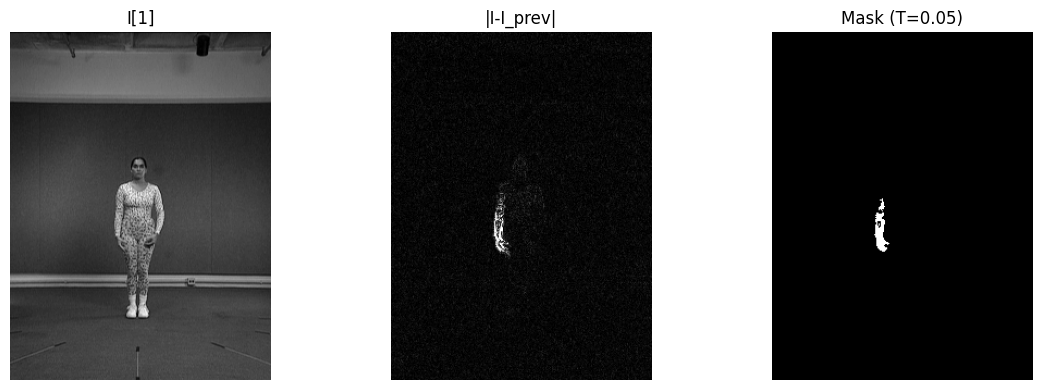

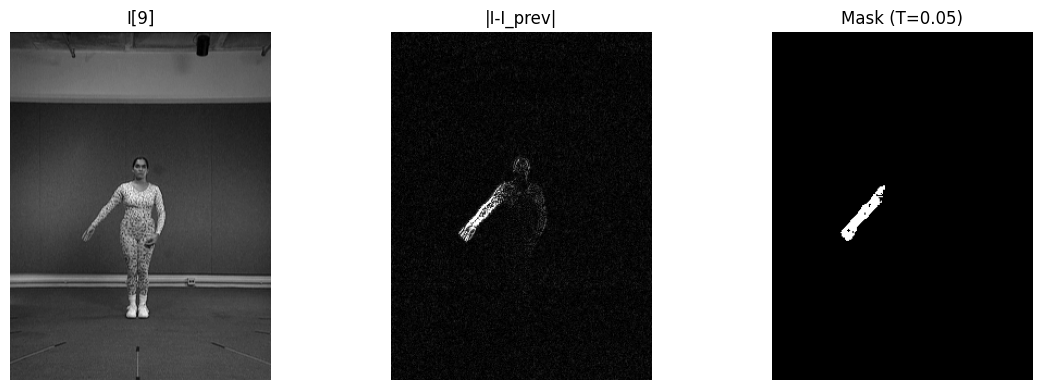

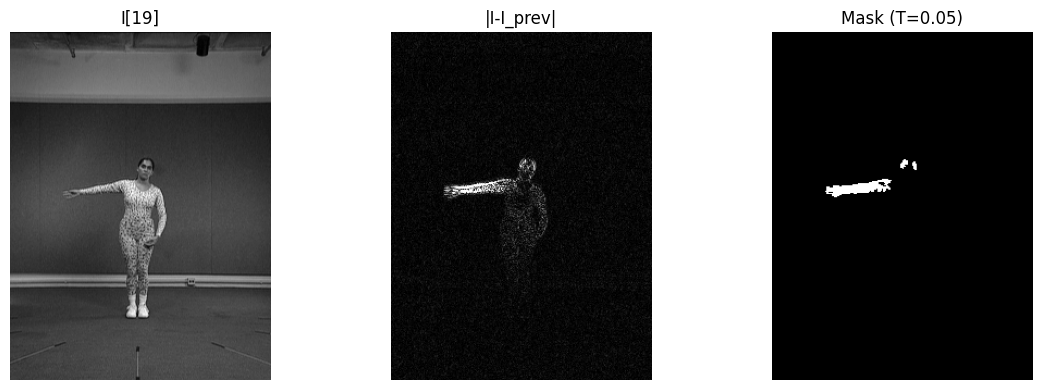

Done.


In [9]:
# 1) Load sequence
frames, paths = load_sequence()
print(f"Loaded {len(frames)} frames: {paths[0]} .. {paths[-1]}")

# 2) Process consecutive pairs: abs diff -> threshold -> median -> remove small regions
results = []  # (i, mask)
for i in range(1, len(frames)):
    diff = np.abs(frames[i] - frames[i-1])
    mask = (diff >= T).astype(np.uint8)
    if MED_K > 1:
        mask = (median_filter2d(mask.astype(np.float32), k=MED_K) >= 0.5).astype(np.uint8)
    mask = remove_small_regions(mask, min_size=MIN_SIZE)
    results.append((i, mask))

# 3) Quick visual check on a few indices (edit list as desired)
sample_is = [2, 10, 20] if len(frames) > 20 else [min(2, len(frames)-1)]
for i in sample_is:
    diff = np.abs(frames[i] - frames[i-1])
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    ax[0].imshow(frames[i-1], cmap="gray"); ax[0].set_title(f"I[{i-1}]"); ax[0].axis("off")
    ax[1].imshow(diff, cmap="gray", vmin=0, vmax=0.2); ax[1].set_title("|I-I_prev|"); ax[1].axis("off")
    mask = dict(results)[i]
    ax[2].imshow(mask, cmap="gray"); ax[2].set_title(f"Mask (T={T})"); ax[2].axis("off")
    plt.tight_layout(); plt.show()

# 4) (Optional) Save masks
# outdir = "outputs/q1_min"
# os.makedirs(outdir, exist_ok=True)
# for i, m in results:
#     Image.fromarray((m*255).astype(np.uint8)).save(os.path.join(outdir, f"mask_{i:03d}.png"))

print("Done.")
